# Stage 1 Junk Elmination

10-class model for isolating pictorial content that is integrated into the page ("inline images").

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [4]:
# using local data uploaded as .zip (~12GB) from Google Cloud bucket
path = Path("/home/jupyter/sandbox/19c-book-illustrations"); path

PosixPath('/home/jupyter/sandbox/19c-book-illustrations')

In [5]:
# these 10 directories contain the classes (nothing is split into test/train/validate yet)
path.ls()

[PosixPath('/home/jupyter/sandbox/19c-book-illustrations/map'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/plate_image'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/inline_image'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/bookplate'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/music'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/verse'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/colored_papers'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/models'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/text'),
 PosixPath('/home/jupyter/sandbox/19c-book-illustrations/tabular')]

In [6]:
# Set the random seed for consistency when doing the training splits
np.random.seed(2)

In [7]:
# TODO: these transforms are mainly for color photography... do they help?
tfms = get_transforms()

In [ ]:
# data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [9]:
# Create the DataBunch. See:
# https://forums.fast.ai/t/unable-to-create-imagedatabunch-from-folders/36923
# https://forums.fast.ai/t/imageitemlist-not-defined/41245 (due to Class being renamed)
#
data = (ImageList.
        from_folder(path).
        split_by_rand_pct().
        label_from_folder().
        transform(tfms, size=224).
        databunch())

# change to resnet50?
# data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=299, bs=bs//2).normalize(imagenet_stats)
# learn = cnn_learner(data, models.resnet50, metrics=error_rate)

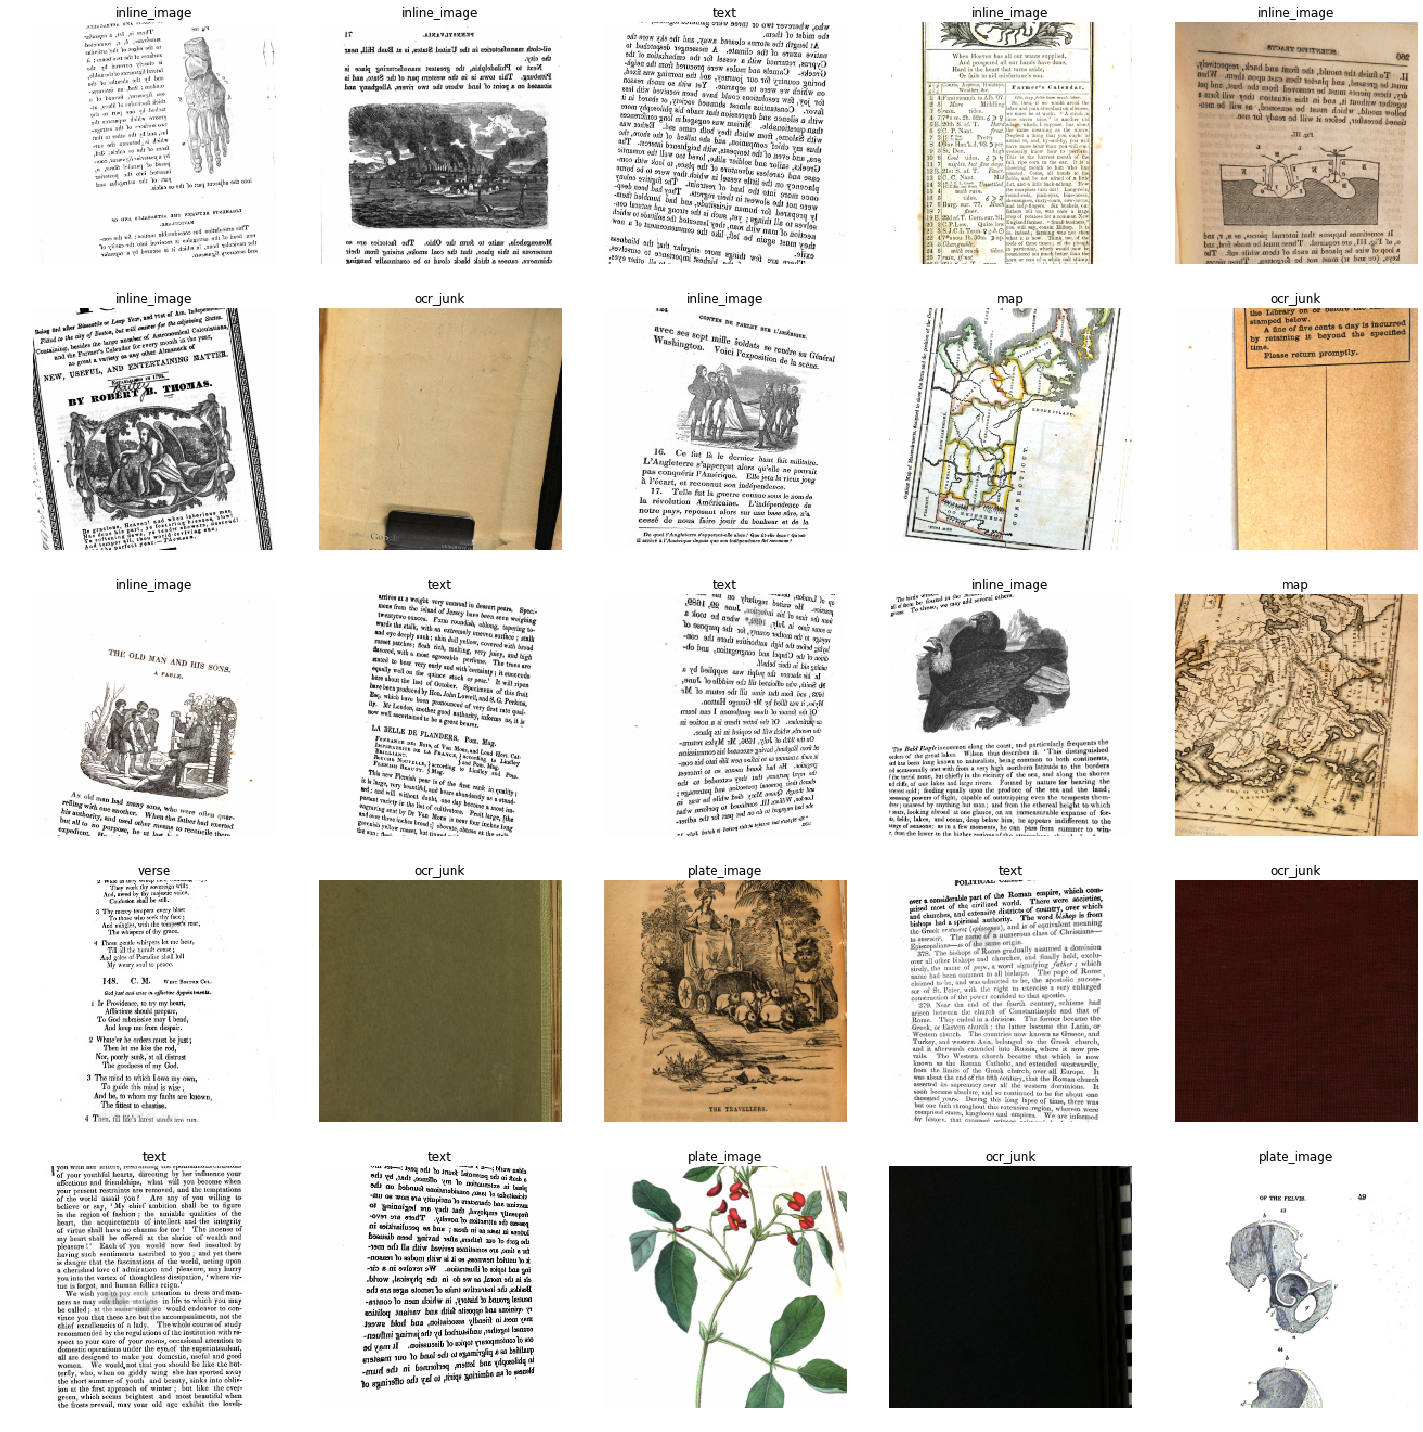

In [33]:
data.show_batch()

In [10]:
print(data.classes)
len(data.classes),data.c

['bookplate', 'colored_papers', 'inline_image', 'map', 'music', 'ocr_junk', 'plate_image', 'tabular', 'text', 'verse']


(10, 10)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories.

We will train for 4 epochs (4 cycles through all our data).

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (4593 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
map,map,map,map,map
Path: /home/jupyter/sandbox/19c-book-illustrations;

Valid: LabelList (1148 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
inline_image,bookplate,ocr_junk,verse,verse
Path: /home/jupyter/sandbox/19c-book-illustrations;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [39]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.004580,0.294468,0.081882,02:43
1,0.515574,0.201986,0.057491,02:41
2,0.367785,0.186820,0.059233,02:40
3,0.306216,0.187071,0.055749,02:39


In [41]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

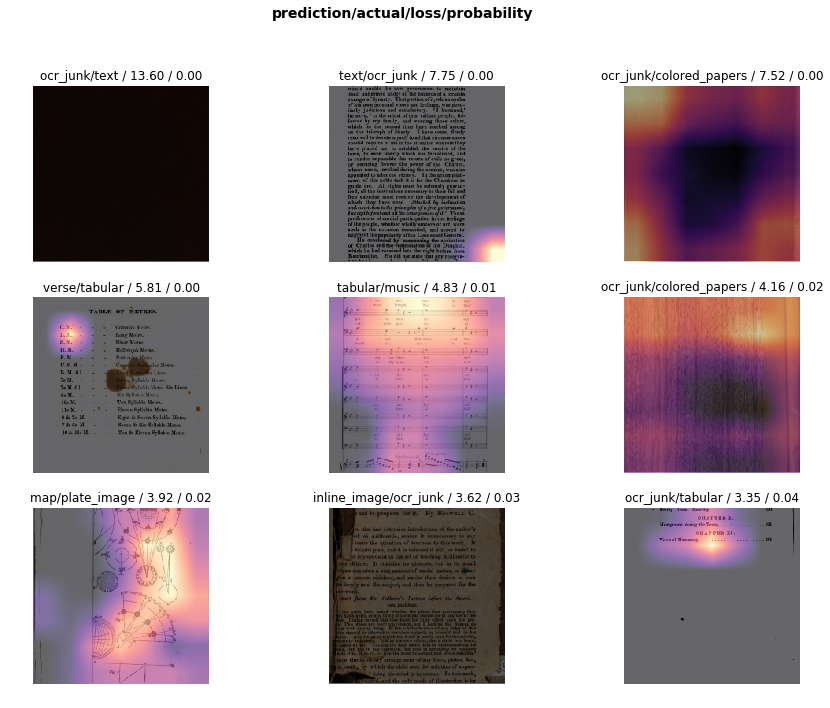

In [43]:
interp.plot_top_losses(9, figsize=(15,11))

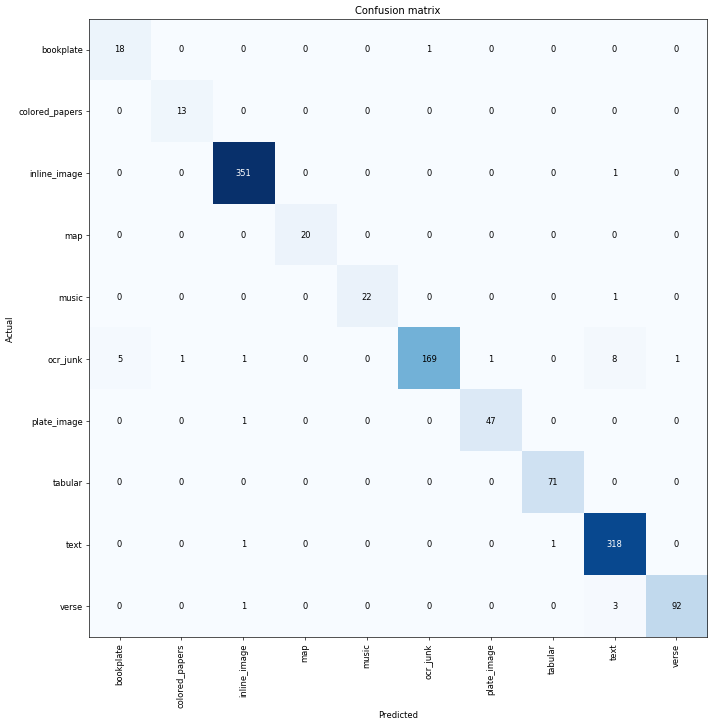

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
interp.most_confused(min_val=2)

[('ocr_junk', 'text', 8), ('ocr_junk', 'bookplate', 5), ('verse', 'text', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.286522,0.169744,0.058362,03:57


In [18]:
learn.save('stage-3');

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


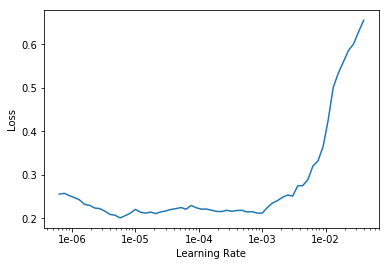

In [20]:
learn.recorder.plot()

In [21]:
# find the most consistent deepest loss decline
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,8e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.210672,0.156541,0.054007,03:07
1,0.178245,0.146379,0.050523,03:07


In [22]:
learn.save('stage-3')

In [23]:
# now lets do the cleaning
from fastai.widgets import *

In [25]:
db = (ImageList.from_folder(path)
                   .split_none() # extra param to get ALL paths
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch())

In [26]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-3')
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [28]:
# in descending order of how confused/wrong the predictions were
ds, idxs

(LabelList (5741 items)
 x: ImageList
 Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
 y: CategoryList
 map,map,map,map,map
 Path: /home/jupyter/sandbox/19c-book-illustrations,
 tensor([ 555, 3555,  511,  ..., 3225, 3564, 3244]))

In [46]:
# widget-free way to get the paths for the 20 most wrong predictions
# https://forums.fast.ai/t/imagecleaner-missing-argument-in-lesson-2-download-notebook/36537/36
losses,idxs = interp.top_losses(20)
data.valid_ds.x.items[idxs]

array([PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/203.png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/verse/128.png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/verse/529.png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/2 (80).png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/184.png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/verse/154 (1).png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/473 (1).png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/225 (2).png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/2 (52).png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/505.png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/ocr_junk/491.png'),
       PosixPath('/home/jupyter/sandbox/19c-book-illustrations/plate_image/453

In [44]:
# https://forums.fast.ai/t/imagecleaner-hangs-for-large-data-sets/42151
#ImageCleaner(ds, idxs, path)

In [ ]:
learn.export()

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
img

In [ ]:
learn = load_learner('export.pkl')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

https://alexiej.github.io/deepnn/#open-mask-fn

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.